In [20]:
pip install catboost


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


### 1. *Import LIBRARIES*


In [9]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.dummy import DummyRegressor
from catboost import CatBoostRegressor, Pool
import matplotlib.pyplot as plt

## 2. *Load Dataset*

In [10]:
df = pd.read_csv("crop_yield.csv")
df.columns = df.columns.str.strip().str.replace(" ", "_").str.lower()

### 3. *DISPLAYING DATASET*

In [11]:
df

crop  crop_year       season              state      area  \
0           Arecanut       1997  Whole Year               Assam   73814.0   
1          Arhar/Tur       1997  Kharif                   Assam    6637.0   
2        Castor seed       1997  Kharif                   Assam     796.0   
3           Coconut        1997  Whole Year               Assam   19656.0   
4       Cotton(lint)       1997  Kharif                   Assam    1739.0   
...              ...        ...          ...                ...       ...   
19684  Small millets       1998  Kharif                Nagaland    4000.0   
19685          Wheat       1998  Rabi                  Nagaland    1000.0   
19686          Maize       1997  Kharif       Jammu and Kashmir  310883.0   
19687           Rice       1997  Kharif       Jammu and Kashmir  275746.0   
19688          Wheat       1997  Rabi         Jammu and Kashmir  239344.0   

       production  annual_rainfall   fertilizer  pesticide        yield  
0           56708           2051.4   7024878.38   22882.34     0.796087  
1            4685           2051.4    631643.29    2057.47     0.710435  
2              22           2051.4     75755.32     246.76     0.238333  
3       126905000           2051.4   1870661.52    6093.36  5238.051739  
4             794           2051.4    165500.63     539.09     0.420909  
...           ...              ...          ...        ...          ...  
19684        2000           1498.0    395200.00    1160.00     0.500000  
19685        3000           1498.0     98800.00     290.00     3.000000  
19686      440900           1356.2  29586735.11   96373.73     1.285000  
19687        5488           1356.2  26242746.82   85481.26     0.016667  
19688      392160           1356.2  22778368.48   74196.64     1.261818  

[19689 rows x 10 columns]

## 3. *Data Cleansing*
Data cleansing improves data quality by fixing errors, removing duplicates, handling missing values, and standardizing formats. This ensures accurate analysis, reliable insights, and better-performing models.

In [12]:
df = df.drop_duplicates()
df = df[(df['area'] > 0) & (df['production'] >= 0)]
low, high = df['yield'].quantile([0.005, 0.995])
df['yield'] = df['yield'].clip(low, high)

## 4. *Feature Engineering*
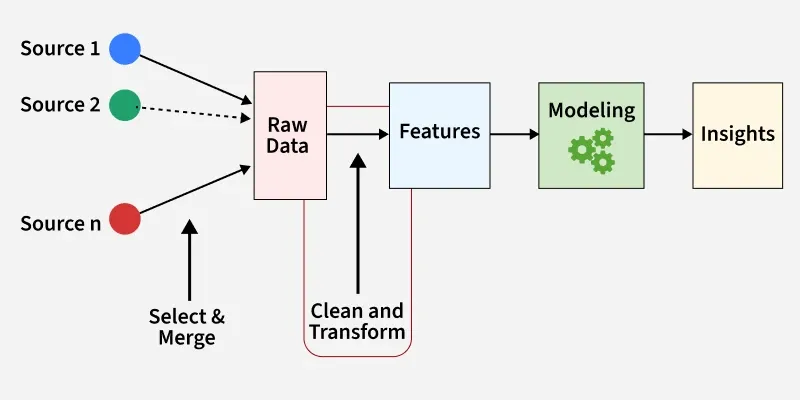

Feature engineering is the process of creating, modifying, or selecting features (columns) from raw data to make it more suitable for machine learning models. Good features help models learn patterns better and improve accuracy.

In [13]:
df = df.drop(columns=['production'])
df['decade'] = (df['crop_year'] // 10) * 10
df['rainfall_fertilizer_ratio'] = df['annual_rainfall'] / (df['fertilizer'] + 1)
df['fert_pest_ratio'] = df['fertilizer'] / (df['pesticide'] + 1)


In [14]:
df['yield_lag1'] = df.groupby(['state','crop'])['yield'].shift(1)
df['yield_lag2'] = df.groupby(['state','crop'])['yield'].shift(2)

### 5. *Train / Validation Split*

In [15]:
train = df[df['crop_year'] <= 2016]
valid = df[df['crop_year'] > 2016]

In [16]:
features = [c for c in df.columns if c not in ['yield']]
cat_features = ['crop','season','state']

In [27]:
train_pool = Pool(train[features], train['yield'], 
                  cat_features=cat_features) 
valid_pool = Pool(valid[features], valid['yield'], 
                  cat_features=cat_features)

### 6. *BaseLine Model*
Baseline model is a simple initial model used to set a reference point for performance. It helps you compare and measure improvements when building more complex models.

In [17]:
dummy = DummyRegressor(strategy="mean")

## 7. *CatBoost Model*
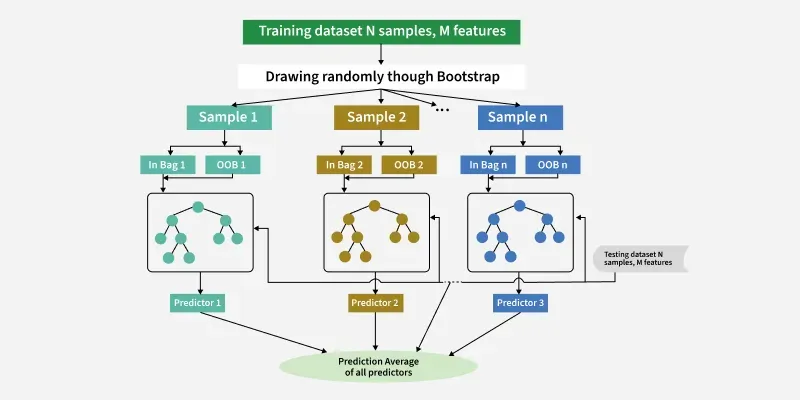
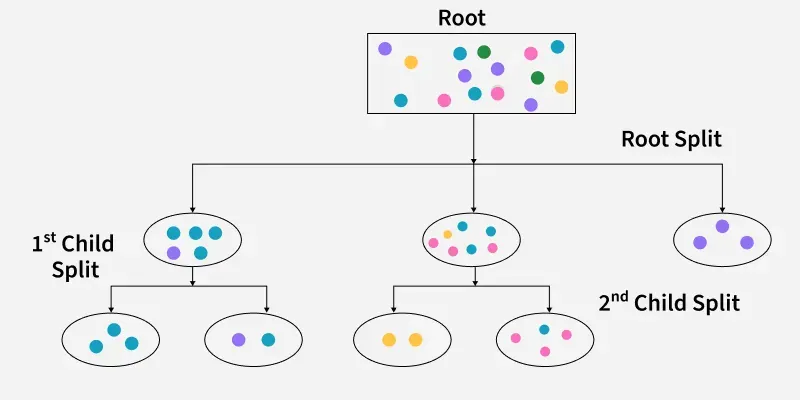

Handles Categorical Features Easily – Variables are naturally categorical. CatBoost processes them directly without manual encoding.

High Accuracy on Tabular Data – Crop datasets often have structured, tabular data. CatBoost performs very well on such datasets.

Reduces Overfitting – Ordered boosting in CatBoost helps the model generalize better, giving more reliable yield predictions.

Fast Training with GPU Support – Useful if your dataset is large (e.g., multiple states, years, and weather data).

Robust Out-of-the-Box Performance – Even with minimal hyperparameter tuning, it gives strong results, saving time.


In [29]:
model = CatBoostRegressor(
    depth=8,
    learning_rate=0.05,
    iterations=2000,
    loss_function='RMSE',
    eval_metric='RMSE',
    early_stopping_rounds=100,
    random_seed=42,
    verbose=200
)
model.fit(train_pool,eval_set = valid_pool)

0:	learn: 596.1120236	test: 577.5375419	best: 577.5375419 (0)	total: 207ms	remaining: 6m 54s
200:	learn: 36.1926997	test: 33.7615030	best: 32.9648512 (159)	total: 8.11s	remaining: 1m 12s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 32.96485122
bestIteration = 159

Shrink model to first 160 iterations.


### 8. *Evaluation*

In [ ]:
valid['pred'] = model.predict(valid[features])
rmse = np.sqrt(mean_squared_error(valid['yield'], valid['pred']))
mae = mean_absolute_error(valid['yield'], valid['pred'])
r2 = r2_score(valid['yield'], valid['pred'])

print(f"Validation RMSE: {rmse:.2f}")
print(f"Validation MAE: {mae:.2f}")
print(f"Validation R2: {r2:.3f}")


Validation RMSE: 33.72
Validation MAE: 3.08
Validation R2: 0.997


## 9. *Feature Importance*

Feature importance tells us how much each input variable (feature) contributes to the predictions of a machine learning model. It helps identify which factors have the biggest impact on the target.
Like:
Rainfall, temperaturemight be more important than fertilizer type.
Helps focus on key factors affecting crop yield.
Guides feature selection and improves model interpretability.

In [ ]:
fi = model.get_feature_importance(prettified=True) 
print(fi)

                   Feature Id  Importances
0                  yield_lag1    66.747094
1                  yield_lag2    28.616654
2                        crop     1.425988
3             annual_rainfall     1.333336
4                        area     0.491235
5                      decade     0.258388
6                       state     0.231124
7                   pesticide     0.185018
8             fert_pest_ratio     0.178574
9   rainfall_fertilizer_ratio     0.165951
10                  crop_year     0.146580
11                 fertilizer     0.135437
12                     season     0.084621


#### 10. *PLOTTING*

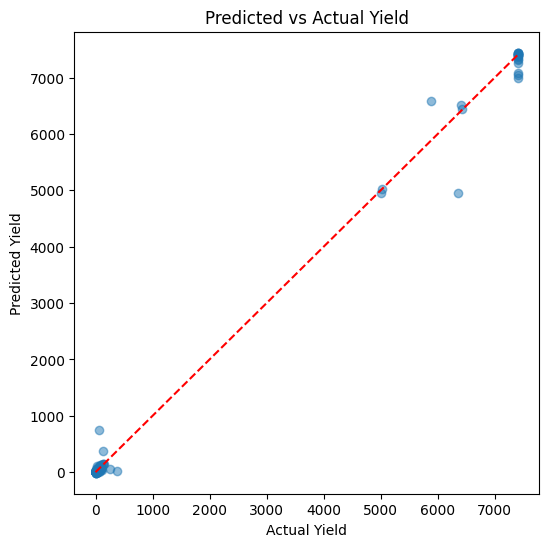

In [ ]:
plt.figure(figsize=(6,6)) 
plt.scatter(valid['yield'], valid['pred'], alpha=0.5) 
plt.plot([valid['yield'].min(), valid['yield'].max()], [valid['yield'].min(), valid['yield'].max()], 'r--') 
plt.xlabel("Actual Yield") 
plt.ylabel("Predicted Yield") 
plt.title("Predicted vs Actual Yield") 
plt.show()

### *Rainfall Trends Across Decades and States*

In [ ]:
df.columns = df.columns.str.strip().str.lower()
print(df.columns.tolist())


['crop', 'crop_year', 'season', 'state', 'area', 'annual_rainfall', 'fertilizer', 'pesticide', 'yield', 'decade', 'rainfall_fertilizer_ratio', 'fert_pest_ratio', 'yield_lag1', 'yield_lag2']


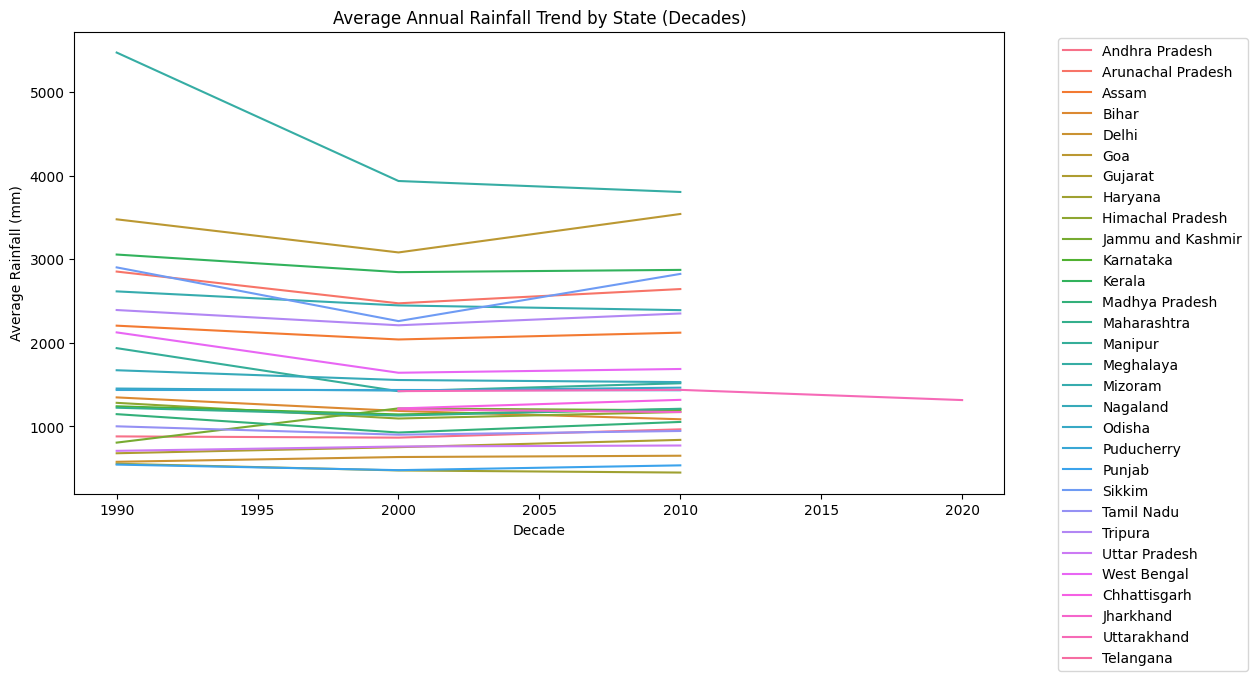

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Rainfall trend by decade
rainfall_decade = df.groupby(['decade','state'])['annual_rainfall'].mean().reset_index()

plt.figure(figsize=(12,6))
sns.lineplot(data=rainfall_decade, x='decade', y='annual_rainfall', hue='state')
plt.title("Average Annual Rainfall Trend by State (Decades)")
plt.xlabel("Decade")
plt.ylabel("Average Rainfall (mm)")
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.show()


#### *Correlation Heatmaps (Rainfall, Fertilizer, Pesticide vs Yield)*

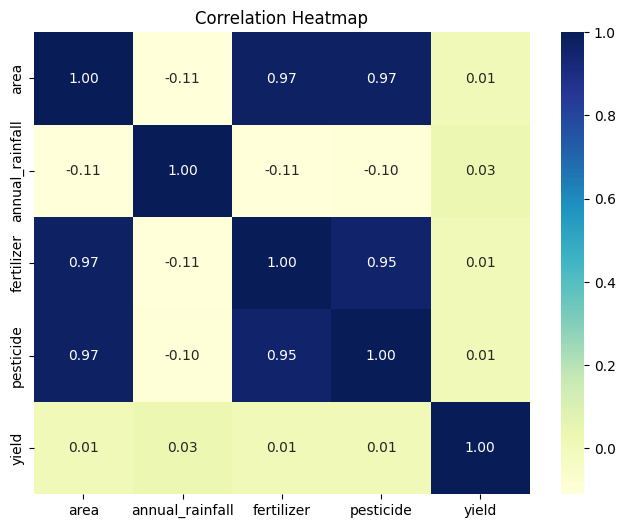

In [ ]:
# Select only numeric features
num_cols = ['area','annual_rainfall','fertilizer','pesticide','yield']
corr = df[num_cols].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='YlGnBu', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


### *Which Crops are Most Fertilizer/Pesticide Dependent*


In [ ]:
# Group by crop and calculate correlations
crop_corr = (
    df.groupby("crop")[["fertilizer", "pesticide", "yield"]]
      .corr()
      .reset_index()
)

# Keep only rows where the second variable is 'yield'
crop_corr = crop_corr[crop_corr["level_1"] == "yield"]

# Now pivot to get clearer columns
crop_corr = crop_corr.pivot(index="crop", columns="level_1", values=["fertilizer","pesticide"])
crop_corr.columns = ["fertilizer_corr", "pesticide_corr"]

print("Top fertilizer-dependent crops:")
print(crop_corr.sort_values("fertilizer_corr", ascending=False).head(10))

print("\nTop pesticide-dependent crops:")
print(crop_corr.sort_values("pesticide_corr", ascending=False).head(10))


Top fertilizer-dependent crops:
                fertilizer_corr  pesticide_corr
crop                                           
Tapioca                0.739684        0.703258
Arecanut               0.711270        0.679091
Jute                   0.688294        0.673249
Castor seed            0.648721        0.628214
other oilseeds         0.620541        0.663905
Oilseeds total         0.597837        0.497780
Wheat                  0.447305        0.437781
Ginger                 0.426047        0.404197
Mesta                  0.374082        0.314457
Barley                 0.299762        0.279306

Top pesticide-dependent crops:
                fertilizer_corr  pesticide_corr
crop                                           
Tapioca                0.739684        0.703258
Arecanut               0.711270        0.679091
Jute                   0.688294        0.673249
other oilseeds         0.620541        0.663905
Castor seed            0.648721        0.628214
Oilseeds total         0

#### *Geospatial Visualization (Yield by State)*

In [ ]:
pip install nbformat --upgrade

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
pip install nbformat


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
pip install jupyterlab

   ---------------------------------------- 0.0/12.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/12.3 MB 1.4 MB/s eta 0:00:09
   ---------------------------------------- 0.1/12.3 MB 1.2 MB/s eta 0:00:11
   ---------------------------------------- 0.1/12.3 MB 901.1 kB/s eta 0:00:14
    --------------------------------------- 0.2/12.3 MB 984.6 kB/s eta 0:00:13
    --------------------------------------- 0.2/12.3 MB 958.4 kB/s eta 0:00:13
    --------------------------------------- 0.2/12.3 MB 1.0 MB/s eta 0:00:12
    --------------------------------------- 0.3/12.3 MB 930.9 kB/s eta 0:00:13
   - -------------------------------------- 0.3/12.3 MB 967.8 kB/s eta 0:00:13
   - -------------------------------------- 0.4/12.3 MB 969.8 kB/s eta 0:00:13
   - -------------------------------------- 0.4/12.3 MB 946.4 kB/s eta 0:00:13
   - -------------------------------------- 0.4/12.3 MB 949.4 kB/s eta 0:00:13
   - -------------------------------------- 0.5/12.3 MB 962.6 kB/s 


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
print(df.columns.tolist())


['State', 'Rainfall', 'Yield']


In [ ]:
#Plot map
import pandas as pd
import plotly.graph_objects as go
import requests

# --- Example DataFrame (replace with your actual df) ---
# df should already be loaded with columns: State, Rainfall, Yield
# Group by state to get averages
state_data = df.groupby("State")[["Rainfall", "Yield"]].mean().reset_index()

# --- Load India states GeoJSON ---
url = "https://raw.githubusercontent.com/geohacker/india/master/state/india_telengana.geojson"
geojson = requests.get(url).json()

# --- Create the choropleth map ---
fig = go.Figure()

# Rainfall map
fig.add_trace(go.Choropleth(
    geojson=geojson,
    featureidkey="properties.NAME_1",  
    locations=state_data["State"],
    z=state_data["Rainfall"],
    colorscale="Blues",  # 🌧️ Rainfall in blues
    colorbar=dict(title="Rainfall", x=0.9),  # Shifted left
    marker_line_width=0.5,
    marker_line_color="black",
    name="Rainfall",
    zmin=state_data["Rainfall"].min(),
    zmax=state_data["Rainfall"].max()
))

# Yield map
fig.add_trace(go.Choropleth(
    geojson=geojson,
    featureidkey="properties.NAME_1",
    locations=state_data["State"],
    z=state_data["Yield"],
    colorscale="Greens",  # 🌾 Yield in greens
    colorbar=dict(title="Yield", x=1.05),  # Shifted right to avoid overlap
    marker_line_width=0.5,
    marker_line_color="black",
    showscale=True,
    name="Yield",
    zmin=state_data["Yield"].min(),
    zmax=state_data["Yield"].max()
))

# --- Map Layout ---
fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(
    title_text="Average Rainfall and Yield (India)",
    title_x=0.5,
    geo=dict(scope="asia"),
)

# --- Show in browser ---
fig.show(renderer="browser")
